# 필요 라이브러리 호출

In [1]:
# 기폰 패키지
import pandas as pd
import numpy as np
from selenium import webdriver
from bs4 import BeautifulSoup
from html_table_parser import parser_functions as parser
import time
import matplotlib.pyplot as plt

# 전처리 패키지
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# 모델 패키지
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import keras
from keras import models
from keras import layers

Using TensorFlow backend.
C:\Anaconda3\envs\nlp\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\envs\nlp\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\envs\nlp\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\envs\nlp\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Future

# 데이터 크롤링

In [ ]:
from mlb_data_crawling import hit_data, field_data

# 데이터 전처리

In [3]:
df_total_hit = pd.read_excel("./backup/df_total_hit.xlsx")
df_total_field = pd.read_excel("./backup/df_total_field.xlsx")

In [4]:
player_hit_data = df_total_hit
player_field_data = df_total_field

In [5]:
# 불필요한 컬럼 삭제

player_hit_data = player_hit_data.drop(['Unnamed: 0', 'RK', 'del', 'del2', 'GO_AO', 'G'], axis=1)
player_field_data = player_field_data.drop(['Unnamed: 0', 'RK', 'del', 'del2', 'G', 'GS', 'SB', 'CS', 'SBPCT','PB','C_WP'], axis=1)

# column Player & Team $ Position 기준 병합

df_total = pd.merge(player_hit_data, player_field_data, on=['Player', 'Team', 'Pos']) # how='outer')
df_total.columns
#df_total.to_excel("test.xlsx")


Index(['Player', 'Team', 'Pos', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB',
       'SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS', 'IBB', 'HBP', 'SAC', 'SF',
       'TB', 'XBH', 'GDP', 'GO', 'AO', 'NP', 'PA', 'INN', 'TC', 'PO', 'A', 'E',
       'DP', 'FPCT', 'RF'],
      dtype='object')

In [6]:
# 컬럼 조건문으로 행 추출하기 Position 컬럼에서 "1B", "2B", "3B", "SS"

# 하나의 조건문이라면 "해당 컬럼 == 하나조건"으로 하면 되지만, "해당컬럼.isin([여러조건])"
# df_total_hit_infld = df_total_hit[df_total_hit['Pos'] == "2B"]
df_total_infld = df_total[df_total['Pos'].isin(["1B", "2B", "3B", "SS"])]
df_total_infld
print(df_total_infld.shape)

# 타석수와 수비이닝의 최소값 제한

df_total_infld = df_total_infld[df_total_infld['AB'] >= 50]
print(df_total_infld.shape)
df_total_infld = df_total_infld[df_total_infld['INN'] >= 50]
print(df_total_infld.shape)

(288, 37)
(244, 37)
(244, 37)


In [7]:
# Null 여부 확인

df_total_infld.isnull().count()

Player    244
Team      244
Pos       244
AB        244
R         244
H         244
2B        244
3B        244
HR        244
RBI       244
BB        244
SO        244
SB        244
CS        244
AVG       244
OBP       244
SLG       244
OPS       244
IBB       244
HBP       244
SAC       244
SF        244
TB        244
XBH       244
GDP       244
GO        244
AO        244
NP        244
PA        244
INN       244
TC        244
PO        244
A         244
E         244
DP        244
FPCT      244
RF        244
dtype: int64

In [8]:
# Playe와 Team 컬럼 삭제

df_total_infld.drop(['Player', 'Team'], axis=1, inplace=True)
df_total_infld.drop(['AB', 'INN'], axis=1, inplace=True)
# df_total_infld.drop(['AVG', 'OBP', 'SLG', 'FPCT'], axis=1, inplace=True)

df_total_infld['AVG'] = df_total_infld['AVG'].astype(float)
df_total_infld['OBP'] = df_total_infld['OBP'].astype(float)
df_total_infld['SLG'] = df_total_infld['SLG'].astype(float)
df_total_infld['FPCT'] = df_total_infld['FPCT'].astype(float)
df_total_infld.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 22 to 688
Data columns (total 33 columns):
Pos     244 non-null object
R       244 non-null int64
H       244 non-null int64
2B      244 non-null int64
3B      244 non-null int64
HR      244 non-null int64
RBI     244 non-null int64
BB      244 non-null int64
SO      244 non-null int64
SB      244 non-null int64
CS      244 non-null int64
AVG     244 non-null float64
OBP     244 non-null float64
SLG     244 non-null float64
OPS     244 non-null float64
IBB     244 non-null int64
HBP     244 non-null int64
SAC     244 non-null int64
SF      244 non-null int64
TB      244 non-null int64
XBH     244 non-null int64
GDP     244 non-null int64
GO      244 non-null int64
AO      244 non-null int64
NP      244 non-null int64
PA      244 non-null int64
TC      244 non-null int64
PO      244 non-null int64
A       244 non-null int64
E       244 non-null int64
DP      244 non-null int64
FPCT    244 non-null float64
RF      244 non-nul

# 데이터 분석하기

In [9]:
# 포지션 별로 각 수치 평균

df_total_infld.groupby('Pos').agg(['mean'])

,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,...,AO,NP,PA,TC,PO,A,E,DP,FPCT,RF
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,...,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Pos,,,,,,,,,,,,,,,,,,,,,
1B,48.534483,84.189655,17.620690,0.879310,16.655172,53.068966,41.103448,89.241379,1.482759,0.655172,...,86.103448,1564.258621,384.862069,591.517241,533.189655,53.586207,4.741379,52.982759,0.991207,5.598103
2B,40.985294,77.985294,14.882353,1.705882,9.970588,36.558824,25.426471,66.220588,5.000000,1.970588,...,79.411765,1284.088235,332.882353,299.455882,129.617647,163.676471,6.161765,39.602941,0.976176,3.037500
3B,46.895522,84.761194,17.746269,1.507463,14.268657,47.179104,32.208955,77.597015,2.970149,1.208955,...,85.880597,1427.611940,362.000000,246.567164,103.716418,135.462687,7.388060,19.776119,0.969716,2.613582
SS,51.921569,96.843137,20.117647,2.254902,13.235294,46.352941,28.098039,79.274510,7.607843,2.725490,...,93.176471,1513.470588,395.254902,350.078431,116.019608,225.058824,9.000000,47.470588,0.975039,3.280784


In [10]:
df_total_infld.describe()

,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,...,AO,NP,PA,TC,PO,A,E,DP,FPCT,RF
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,...,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,46.688525,85.262295,17.413934,1.569672,13.422131,45.446721,31.573770,77.545082,4.151639,1.606557,...,85.655738,1438.040984,366.270492,364.938525,215.594262,142.590164,6.754098,38.983607,0.977738,3.580615
std,31.251688,53.335309,11.646931,1.977045,11.319076,31.514208,23.825987,43.462699,6.459557,2.125903,...,53.572960,805.259173,204.318119,280.713260,261.610105,115.275177,5.141314,30.966325,0.015712,1.678170
min,3.000000,7.000000,0.000000,0.000000,0.000000,3.000000,1.000000,11.000000,0.000000,0.000000,...,6.000000,218.000000,56.000000,21.000000,8.000000,1.000000,0.000000,1.000000,0.929000,1.220000
25%,19.750000,36.000000,7.000000,0.000000,4.000000,17.750000,13.000000,40.000000,0.000000,0.000000,...,36.750000,706.250000,173.000000,155.500000,65.500000,48.000000,3.000000,14.000000,0.970000,2.405000
50%,41.500000,78.000000,17.000000,1.000000,11.000000,40.000000,25.000000,71.500000,2.000000,1.000000,...,77.500000,1379.000000,354.000000,296.500000,131.500000,111.500000,5.500000,29.000000,0.980000,3.150000
75%,69.250000,129.000000,25.000000,2.000000,20.000000,67.500000,44.250000,109.500000,5.000000,2.000000,...,127.250000,2091.750000,546.250000,494.000000,208.750000,231.250000,10.000000,60.250000,0.990000,3.972500
max,129.000000,206.000000,54.000000,10.000000,53.000000,126.000000,119.000000,189.000000,43.000000,10.000000,...,221.000000,3223.000000,747.000000,1372.000000,1296.000000,436.000000,26.000000,145.000000,1.000000,8.800000


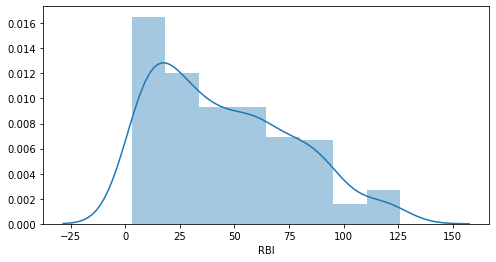

In [11]:
import seaborn as sns
plt.figure(figsize=(8,4))
# plt.xticks(range(0,60,5), rotation=60)
sns.distplot(df_total_infld['RBI'])

### 피쳐간에 상관도 분석

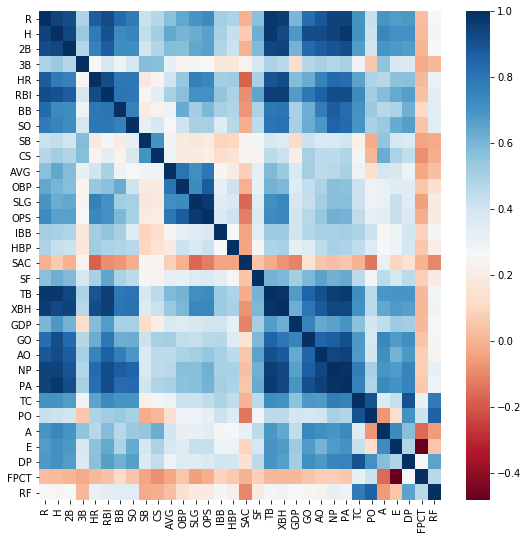

In [12]:
# 이상치 찾아내는 방법
# DataFrame의 corr()를 이용해 피처별로 상관도 구하고 heatmap 시각화
import seaborn as sns

plt.figure(figsize=(9,9))
corr = df_total_infld.corr()
sns.heatmap(corr, cmap="RdBu")

- cmap-"RdBu" 
- 양의 상관관계가 높을 수록 - 진한 파란색
- 음의 상관관계가 높을 수록 - 진한 빨간색

# 데이터 레이블 및 데이터 세트 분리

In [13]:
# label 데이터 레이블 인코딩
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df_total_infld['Pos'])
df_total_infld['Pos'] = encoder.transform(df_total_infld['Pos'])
#labels = labels.reshape(-1, 1)
print(df_total_infld[:5])

    Pos    R    H  2B  3B  HR  RBI  BB   SO  SB  ...   AO    NP   PA   TC  \
22    2   61  115  23   1  17   62  27   49   2  ...   82  1397  370  401   
23    3   81  167  32   0  18   56  15  109  17  ...   93  1765  518  532   
24    1   54  109  20   1   4   28  36   29   2  ...  105  1486  366  227   
37    3   27   71  13   1   4   23  10   49   0  ...   54   903  228  199   
40    1  109  197  33   2  26  102  46   90   5  ...  136  2463  655  620   

     PO    A   E  DP   FPCT    RF  
22  308   91   2  35  0.995  4.29  
23  182  324  26  75  0.951  4.11  
24  101  121   5  31  0.978  2.22  
37   84  113   2  27  0.990  3.46  
40  351  261   8  63  0.987  3.64  

[5 rows x 33 columns]


In [32]:
# 데이터 세트 분리 (피처 데이터 and 라벨 데이터)

y_infield_df = df_total_infld['Pos']
x_infield_df = df_total_infld.drop('Pos', axis=1)

In [86]:
# train_test_split()를 통해 train과 test 데이터 분리
# from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_infield_df, y_infield_df, test_size=0.2, random_state=11)

In [87]:
print(x_infield_df.shape)
print(y_infield_df.shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(244, 32)
(244,)
(195, 32)
(195,)
(49, 32)
(49,)


# 학습하기
- Machine Learning 모델 생성

In [88]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)
gb_clf = GradientBoostingClassifier(random_state=0)
xgb_clf = XGBClassifier(n_estimators=100, learning_rate=0.03, max_depth=3)
lgbm_clf = LGBMClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트 예측
lr_final = LogisticRegression(C=10)

In [89]:
# 개별 ML 모델 학습 : fit
knn_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)
dt_clf.fit(x_train, y_train)
ada_clf.fit(x_train, y_train)
gb_clf.fit(x_train, y_train)
xgb_clf.fit(x_train, y_train)
lgbm_clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [90]:
# 학습된 개별 모델들 예측 데이터 생성 후 test 데이터로 정확도 측정
knn_pred = knn_clf.predict(x_test)
rf_pred = rf_clf.predict(x_test)
dt_pred = dt_clf.predict(x_test)
ada_pred = ada_clf.predict(x_test)
gb_pred = gb_clf.predict(x_test)
xgb_pred = xgb_clf.predict(x_test)
lgbm_pred = lgbm_clf.predict(x_test)

In [91]:
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('RF 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('DT 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('ADA 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))
print('GB 정확도: {0:.4f}'.format(accuracy_score(y_test, gb_pred)))
print('XGB 정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))
print('LGBM 정확도: {0:.4f}'.format(accuracy_score(y_test, lgbm_pred)))

KNN 정확도: 0.6122
RF 정확도: 0.6735
DT 정확도: 0.6735
ADA 정확도: 0.5102
GB 정확도: 0.6735
XGB 정확도: 0.7755
LGBM 정확도: 0.6735


In [92]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred, gb_pred, xgb_pred, lgbm_pred])
print(pred.shape)

pred = np.transpose(pred)
print(pred.shape)

lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

(7, 49)
(49, 7)
최종 모델의 예측 정확도: 0.7143


C:\Anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# MinMaxScaler 정규화

In [93]:
scaler = MinMaxScaler()
scaler.fit(x_test)
scaler.fit(x_train)
x_test = scaler.transform(x_test)
x_train = scaler.transform(x_train)
print(x_test.shape, x_train.shape)

(49, 32) (195, 32)


In [94]:
# 개별 ML 모델 학습 : fit
knn_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)
dt_clf.fit(x_train, y_train)
ada_clf.fit(x_train, y_train)
gb_clf.fit(x_train, y_train)
xgb_clf.fit(x_train, y_train)
lgbm_clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [95]:
# 학습된 개별 모델들 예측 데이터 생성 후 test 데이터로 정확도 측정
knn_pred = knn_clf.predict(x_test)
rf_pred = rf_clf.predict(x_test)
dt_pred = dt_clf.predict(x_test)
ada_pred = ada_clf.predict(x_test)
gb_pred = gb_clf.predict(x_test)
xgb_pred = xgb_clf.predict(x_test)
lgbm_pred = lgbm_clf.predict(x_test)

In [96]:
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('RF 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('DT 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('ADA 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))
print('GB 정확도: {0:.4f}'.format(accuracy_score(y_test, gb_pred)))
print('XGB 정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))
print('LGBM 정확도: {0:.4f}'.format(accuracy_score(y_test, lgbm_pred)))

KNN 정확도: 0.5510
RF 정확도: 0.6735
DT 정확도: 0.5918
ADA 정확도: 0.5102
GB 정확도: 0.6531
XGB 정확도: 0.7755
LGBM 정확도: 0.6939


In [97]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred, gb_pred, xgb_pred, lgbm_pred])
print(pred.shape)

pred = np.transpose(pred)
print(pred.shape)

lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

(7, 49)
(49, 7)
최종 모델의 예측 정확도: 0.7347


C:\Anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# 정규화 : 정확도가 상당히 좋지 않아 "정규화'를 해보자

In [98]:
x_train, x_test, y_train, y_test = train_test_split(x_infield_df, y_infield_df, test_size=0.2, random_state=11)

In [99]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

mean = x_test.mean(axis=0)
x_test -= mean
std = x_test.std(axis=0)
x_test /= std

In [100]:
# 개별 ML 모델 학습 : fit
knn_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)
dt_clf.fit(x_train, y_train)
ada_clf.fit(x_train, y_train)
gb_clf.fit(x_train, y_train)
xgb_clf.fit(x_train, y_train)
lgbm_clf.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [101]:
# 학습된 개별 모델들 예측 데이터 생성 후 test 데이터로 정확도 측정
knn_pred = knn_clf.predict(x_test)
rf_pred = rf_clf.predict(x_test)
dt_pred = dt_clf.predict(x_test)
ada_pred = ada_clf.predict(x_test)
gb_pred = gb_clf.predict(x_test)
xgb_pred = xgb_clf.predict(x_test)
lgbm_pred = lgbm_clf.predict(x_test)

In [102]:
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('RF 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('DT 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('ADA 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))
print('GB 정확도: {0:.4f}'.format(accuracy_score(y_test, gb_pred)))
print('XGB 정확도: {0:.4f}'.format(accuracy_score(y_test, xgb_pred)))
print('LGBM 정확도: {0:.4f}'.format(accuracy_score(y_test, lgbm_pred)))

KNN 정확도: 0.5102
RF 정확도: 0.6122
DT 정확도: 0.4898
ADA 정확도: 0.4286
GB 정확도: 0.5918
XGB 정확도: 0.6327
LGBM 정확도: 0.5918


In [103]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred, gb_pred, xgb_pred, lgbm_pred])
print(pred.shape)

pred = np.transpose(pred)
print(pred.shape)

(7, 49)
(49, 7)


In [104]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 모델의 예측 정확도: 0.7755


C:\Anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
